In [1]:
import pandas as pd
import pypsa
import urllib3
import plotly.graph_objects as go
import calendar
urllib3.disable_warnings()

In [2]:
# Load Technology data
year = 2025
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]


In [3]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


In [4]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [5]:
network = pypsa.Network()

In [6]:
def optimizer(year):
    hours_in_year = pd.date_range(f'{year}-01-01 00:00Z',
                                f'{year}-12-31 23:00Z',
                                freq='h')

    network.set_snapshots(hours_in_year.values)

    network.add("Bus",
                "electricity bus", overwrite=True)

    # load electricity demand data
    df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
    df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
    country='IRL'
    print(df_elec[country].head())

    # add load to the bus
    network.add("Load",
        "load",
        bus="electricity bus",
        p_set=df_elec[country].values,
        overwrite=True)
    

    # add the different carriers, only gas emits CO2
    network.add("Carrier", "gas", co2_emissions= costs.at["gas", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "onshorewind", overwrite=True)
    network.add("Carrier", "solar", overwrite=True)
    network.add("Carrier", "coal", co2_emissions = costs.at["coal", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "biomass", co2_emissions = costs.at["biomass", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "oil", co2_emissions = costs.at["oil", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "offshorewind", overwrite=True)

    # add onshore wind generator
    df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
    CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "onshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="onshorewind",
                p_nom_max=4810-25.2, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
                capital_cost = costs.at["onwind", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_wind.values,
                overwrite=True)

    # add solar PV generator
    df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
    df_solar.index = pd.to_datetime(df_solar.index)
    CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "solar",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="solar",
                p_nom_max = 740, # maximum capacity can be limited due to environmental constraints Based on electricity maps
                capital_cost = costs.at["solar", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_solar.values,
                overwrite=True)

    # add OCGT (Open Cycle Gas Turbine) generator
    network.add("Generator",
                "OCGT",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="gas",
                p_nom_max=4270, #based on electricity maps
                capital_cost = costs.at["OCGT", "capital_cost"], #in €/MW
                marginal_cost = costs.at["OCGT", "marginal_cost"],
                overwrite=True)

    # add Coal generator
    network.add("Generator",
                "Coal",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="coal",
                p_nom_max=920, #based on electricity maps
                capital_cost = costs.at["coal", "capital_cost"], #in €/MW
                marginal_cost = costs.at["coal", "marginal_cost"],
                overwrite=True)

    # add biomass generator
    network.add("Generator",
                "Biomass",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="biomass",
                p_nom_max=70, #based on electricity maps 
                capital_cost = costs.at["biomass", "capital_cost"], #in €/MW
                marginal_cost = costs.at["biomass", "marginal_cost"],
                overwrite=True)

    # add oil generator
    network.add("Generator",
                "Oil",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="oil",
                p_nom_max=830, #based on electricity maps
                capital_cost = costs.at["oil", "capital_cost"], #in €/MW
                marginal_cost = costs.at["oil", "marginal_cost"],
                overwrite=True)

    # add offshore wind generator
    df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
    CF_offshorewind = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "offshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="offshorewind",
                p_nom_max=25.2, # maximum capacity can be limited due to environmental constraints. #Ireland doesnt have offshore wind today, but are proposing to install 5GW soon
                capital_cost = costs.at["offwind", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_offshorewind.values,
                overwrite=True)
    

    #Optimization
    status = network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})


    objective = network.objective
    capacities = network.generators.p_nom_opt #in MW
    loadConsumption = network.loads_t.p
    generation = network.generators_t.p
    snapshots = network.snapshots
    
    
    

    return objective, capacities, loadConsumption, generation, snapshots, status




In [7]:
objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015)

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 37.64it/s]
INFO:linopy.io: Writing time: 0.39s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-l893u3rc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-l893u3rc.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131414 rows, 61327 columns, 240914 nonzeros


INFO:gurobipy:obj: 131414 rows, 61327 columns, 240914 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131414 duals
Objective: 2.60e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [8]:
status[1]

'optimal'

In [9]:
def plot_dispatch_winter():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot[:96], y=loadConsumption['load'][:96], mode='lines', name='demand', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['onshorewind'][:96], mode='lines', name='onshore wind', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['solar'][:96], mode='lines', name='solar', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['OCGT'][:96], mode='lines', name='gas (OCGT)', line=dict(color='brown')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Coal'][:96], mode='lines', name='coal', line=dict(color='grey')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Biomass'][:96], mode='lines', name='biomass', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Oil'][:96], mode='lines', name='oil', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['offshorewind'][:96], mode='lines', name='offshore wind', line=dict(color='purple')))

    fig.update_layout(title='Electricity Dispatch Week 1 2015',
                    xaxis_title='Time',
                    yaxis_title='Power (MW)',
                    legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()

In [10]:
plot_dispatch_winter()

# B)

In [11]:
# Add the CO2 constraint to the copied network
co2_limit = 3000000  # tonCO2
network.add("GlobalConstraint",
                 "co2_limit",
                 type="primary_energy",
                 carrier_attribute="co2_emissions",
                 sense="<=",
                 constant=co2_limit,
                 overwrite=True)

Index(['co2_limit'], dtype='object')

In [12]:
objective, capacities, loadConsumption, generation, snapshot, staus = optimizer(2015)
plot_dispatch_winter()

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 37.17it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-tj3yw8jz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-tj3yw8jz.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 9.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [13]:
objectives = {}
capacities_dic = {}
loadConsumptions = {}
generations = {}
snapshots = {}
for Co2_limit in range(2000000, 5000000, 500000):
    network.add("GlobalConstraint",
                 "co2_limit",
                 type="primary_energy",
                 carrier_attribute="co2_emissions",
                 sense="<=",
                 constant=Co2_limit,
                 overwrite=True)
    objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015)
    if status[1] == "optimal":
        objectives[Co2_limit] = objective
        capacities_dic[Co2_limit] = capacities
        loadConsumptions[Co2_limit] = loadConsumption
        generations[Co2_limit] = generation
        snapshots[Co2_limit] = snapshot
    

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 34.47it/s]
INFO:linopy.io: Writing time: 0.42s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-72q9h4a9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-72q9h4a9.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 24.66it/s]
INFO:linopy.io: Writing time: 0.44s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-zdz0g_st.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-zdz0g_st.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 25.30it/s]
INFO:linopy.io: Writing time: 0.44s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-usnl91gr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-usnl91gr.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 9.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 35.21it/s]
INFO:linopy.io: Writing time: 0.41s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-khmtn4dv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-khmtn4dv.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 7.81e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 35.48it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-z__6xxev.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-z__6xxev.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 6.25e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 37.48it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-wp7eijwp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-wp7eijwp.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 4.70e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [14]:
def plot_mix(generator, co2_limit):


    labels = ['onshore wind', 'solar', 'gas (OCGT)', 'coal', 'biomass', 'oil', 'offshore wind']
    sizes = [generator['onshorewind'].sum(),
                    generator['solar'].sum(),
                    generator['OCGT'].sum(),
                    generator['Coal'].sum(),
                    generator['Biomass'].sum(),
                    generator['Oil'].sum(),
                    generator['offshorewind'].sum()]

    colors = ['blue', 'orange', 'brown', 'grey', 'green', 'black', 'purple']

    fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, marker=dict(colors=colors))])

    fig.update_layout(title='Electricity mix',
                      annotations=[dict(text=f"CO2 limit: {co2_limit} tonCO2",
                                       x=0.5, y=1.3, font_size=20, showarrow=False)])

    fig.show()


In [15]:
#plot mix for g in generators and co2_limit
for co2_limit in objectives.keys():
    plot_mix(generations[co2_limit], co2_limit)

Based on research, the CO2-emissions from electricity production was 7.56mT CO2-eq in 2023. This will now be the limit:


In [16]:
network.add("GlobalConstraint",
                 "co2_limit",
                 type="primary_energy",
                 carrier_attribute="co2_emissions",
                 sense="<=",
                 constant=7560000,
                 overwrite=True)
objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015)

plot_mix(generation, 7560000)

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 37.89it/s]
INFO:linopy.io: Writing time: 0.39s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-iak_v5up.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-iak_v5up.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 2.60e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


# C)

In this task we will use a CO2 allowance of 3mT

In [17]:
network.add("GlobalConstraint",
                 "co2_limit",
                 type="primary_energy",
                 carrier_attribute="co2_emissions",
                 sense="<=",
                 constant=3000000,
                 overwrite=True)

objectives = {}
capacities_dic = {}
loadConsumptions = {}
generations = {}
snapshots = {}


for year in range(2013, 2017):
    if not calendar.isleap(year):  # only hit non-leap years
        objective, capacities, loadConsumption, generation, snapshot, status = optimizer(year)
        if status[1] == "optimal":
            print(f"Year {year} is optimal")
            objectives[year] = objective
            capacities_dic[year] = capacities
            loadConsumptions[year] = loadConsumption
            generations[year] = generation
            snapshots[year] = snapshot



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 32.29it/s]
INFO:linopy.io: Writing time: 0.44s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-yv81m6zf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-yv81m6zf.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 131415 rows, 61327 columns, 267206 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267206 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.01e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2013 is optimal
utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 36.18it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-p9dfj76s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-p9dfj76s.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267211 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267211 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.07e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2014 is optimal
utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 36.99it/s]
INFO:linopy.io: Writing time: 0.41s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-bdw2bsiy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-bdw2bsiy.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 9.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2015 is optimal


## Objective with optimal CO2 limit for 2015

In [18]:
objective_optimalCO2, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 32.81it/s]
INFO:linopy.io: Writing time: 0.43s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-6fni1n8s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-6fni1n8s.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 9.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [19]:
#make a 100% stacket area chart of the capacities for all years
def plot_capacities(years):
    fig = go.Figure()

    for generator in ['onshorewind', 'solar', 'OCGT', 'Coal', 'Biomass', 'Oil', 'offshorewind']:
        fig.add_trace(go.Scatter(x=years, y=[capacities_dic[year][generator] for year in years],
                                 mode='lines+markers',
                                 name=generator))

    fig.update_layout(title='Capacities over the years',
                      xaxis_title='Year',
                      yaxis_title='Capacity (MW)',
                      legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_capacities([year for year in range(2013, 2017) if not calendar.isleap(year)])

In [20]:
#make a 100% stacket area chart of the generation for all years
def plot_generation(years):
    fig = go.Figure()

    for generator in ['onshorewind', 'solar', 'OCGT', 'Coal', 'Biomass', 'Oil', 'offshorewind']:
        fig.add_trace(go.Scatter(x=years, y=[sum(generations[year][generator]) for year in years],
                                 mode='lines+markers',
                                 name=generator))

    fig.update_layout(title='Generation over the years',
                      xaxis_title='Year',
                      yaxis_title='Capacity (MW)',
                      legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_generation([year for year in range(2013, 2017) if not calendar.isleap(year)])

# D)

In [21]:
#values for pumped hydro
#costs.loc["Pumped-Storage-Hydro-store", :].T

In [22]:
print(costs.at["Pumped-Storage-Hydro-store", "capital_cost"])
print(costs.at["coal", "capital_cost"])
print(costs.at["offwind", "capital_cost"])
print(costs.at["OCGT", "capital_cost"])
print(costs.at["onwind", "capital_cost"])
print(costs.at["solar", "capital_cost"])
print(costs.at["oil", "capital_cost"])

13694770.916593747
668813344.7589797
248431757.57097575
57685985.73118066
154026277.9441863
112520110.2010592
44506255.460814066


In [23]:
#Create a new carrier
network.add("Carrier",
              "Hydro")

#Create a new bus
network.add("Bus",
          "Hydro Bus",
          carrier = "Hydro")

#Connect the Pumped Hydr Storage (PHS) to the Hydro Bus
network.add("Store",
          "PHS",
          bus = "Hydro Bus",
          e_nom_extendable = True,
          e_cyclic = True,
          e_nom_max = 240, #in MWh
          capital_cost = costs.at["Pumped-Storage-Hydro-store", "capital_cost"], 
          overwrite=True
)

#Add the link "Hydro pump" that transport energy from the electricity bus (bus0) to the Hydro bus (bus1)
#with 80% efficiency
network.add("Link",
          "Hydro pump",
          bus0 = "electricity bus",
          bus1 = "Hydro Bus",
          p_nom_extendable = True,
          efficiency = 0.85,
          capital_cost = 0, 
            overwrite=True
          )

#Add the link "Hydro turbine" that transports energy from the Hydro bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
          "Hydro turbine",
          bus0 = "Hydro Bus",
          bus1 = "electricity bus",
          p_nom_extendable = True,
          efficiency = 0.9,
          capital_cost = 0,
            overwrite=True
        
          )



Index(['Hydro turbine'], dtype='object')

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 78.71it/s]
INFO:linopy.io: Writing time: 0.62s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-8dbu840i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-8dbu840i.lp


Reading time = 0.21 seconds


INFO:gurobipy:Reading time = 0.21 seconds


obj: 201499 rows, 96370 columns, 416118 nonzeros


INFO:gurobipy:obj: 201499 rows, 96370 columns, 416118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 201499 duals
Objective: 9.41e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


<Axes: xlabel='snapshot', ylabel='Hydro storage'>

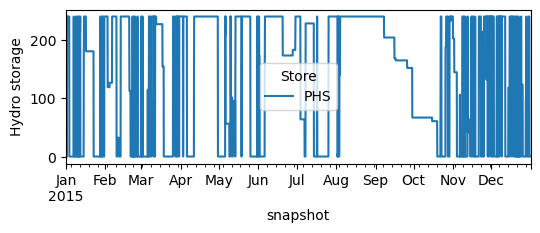

In [24]:

objective_hydro, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")
network.stores_t.e.plot(figsize=(6, 2), ylabel="Hydro storage")



In [ ]:
print("objective_optimalCO2: ", objective_optimalCO2)
print("objective_hydro: ", objective_hydro)

print("Savings using a pumped hydro storage: ", objective_optimalCO2 - objective_hydro)


objective_optimalCO2 949655388041.6951
objective_hydro 941122503492.8068
Savings using a pumped hydro storage 8532884548.888306


In [ ]:
# Re-run the optimizer to ensure 'Hydro Bus' is included in the network
objective_hydro, capacities, loadConsumption, generation, snapshot, status = optimizer(2015)



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump'], dtype='object', name='Link')
Index(['electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 77.36it/s]
INFO:linopy.io: Writing time: 0.61s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-ftvobj96.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-ftvobj96.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 201499 rows, 96370 columns, 416118 nonzeros


INFO:gurobipy:obj: 201499 rows, 96370 columns, 416118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 201499 duals
Objective: 9.41e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


KeyError: 'Hydro Bus'

In [40]:
#print the marginal price from electricity bus
print(network.buses_t.marginal_price['electricity bus'])
#plot the marginal price from electricity bus

def plot_marginal_price():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot, y=network.buses_t.marginal_price['electricity bus'],
                             mode='lines', name='marginal price', line=dict(color='black')))

    fig.update_layout(title='Marginal Price',
                      xaxis_title='Time',
                      yaxis_title='Price (€/MWh)',
                      legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_marginal_price()

snapshot
2015-01-01 00:00:00    71662.261964
2015-01-01 01:00:00    71662.261964
2015-01-01 02:00:00    71662.261964
2015-01-01 03:00:00        0.000000
2015-01-01 04:00:00        0.000000
                           ...     
2015-12-31 19:00:00    71662.261964
2015-12-31 20:00:00    71662.261964
2015-12-31 21:00:00    71662.261964
2015-12-31 22:00:00    71662.261964
2015-12-31 23:00:00    71662.261964
Name: electricity bus, Length: 8760, dtype: float64


# E)

In [41]:
print(network.global_constraints.constant) # CO2 limit (constant in the constraint)
print(network.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

GlobalConstraint
co2_limit    3000000.0
Name: constant, dtype: float64
GlobalConstraint
co2_limit   -361600.193107
Name: mu, dtype: float64
